In [2]:
DATA = r'C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\label_combined.csv'

In [22]:
MODEL_GB = r"C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\Model_Optimized\GB.pkl"
MODEL_RF = r"C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\Model_Optimized\RF.pkl"
MODEL_DT = r"C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\Model_Optimized\DT.pkl"
MODEL_ET = r"C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\Model_Optimized\ET.pkl"
MODEL_AdaB = r"C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\Model_Optimized\AdaB.pkl"
MODEL_NN = r"C:\Users\KIIT\Desktop\SEM-VII\Major Project\UNSW-NB15\Model_Optimized\NN.pkl"

# AdaBoost

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the learning rate for AdaBoost
learning_rate =  0.9769932760006571 # You can adjust this value as needed

# Step 5: Create and train the AdaBoost model
base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
adaboost_model = AdaBoostClassifier(base_estimator=base_model, n_estimators=58, learning_rate=learning_rate, random_state=42)
adaboost_model.fit(X_train, y_train)

# Step 6: Make predictions on the test data
y_pred = adaboost_model.predict(X_test)

# Step 7: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Step 8: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

auc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, adaboost_model.predict_proba(X_test))
print("AUC: {:.6f}".format(auc))
print("Log Loss: {:.6f}".format(logloss))

# import joblib
# # Save the trained classifier model to a file
# model_filename = MODEL_AdaB
# joblib.dump(adaboost_model, model_filename)


Accuracy: 0.9115164451343747
Confusion Matrix:
[[15861  2814]
 [ 1746 31114]]
AUC: 0.898091
Log Loss: 0.629386


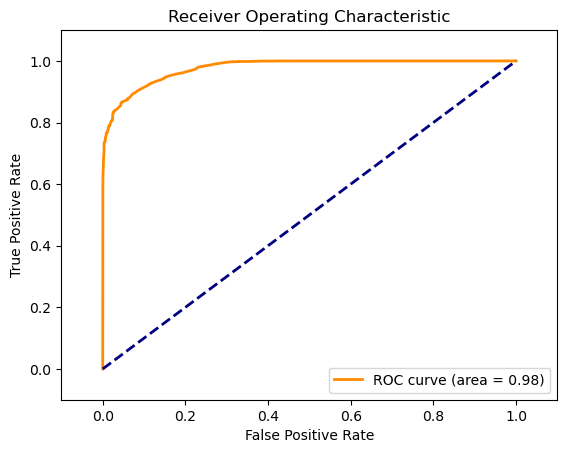

In [4]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, adaboost_model.predict_proba(X_test)[:,1])
roc_auc_value = auc(fpr, tpr)  # Renamed the variable to avoid naming conflict

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### HyperBand

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm  # Import the tqdm module

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the hyperparameter search space for Hyperband
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),  # Number of estimators
    'learning_rate': hp.loguniform('learning_rate', -5, 0),    # Learning rate (log scale)
}

# Step 5: Define the objective function to optimize (accuracy in this case)
def objective(params):
    base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
    adaboost_model = AdaBoostClassifier(
        base_estimator=base_model,
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        random_state=42
    )
    adaboost_model.fit(X_train, y_train)
    y_pred = adaboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Step 6: Perform Hyperband optimization with progress bar
trials = Trials()

# Define the progress bar using tqdm
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

# Step 7: Get the best hyperparameters and train the final model
best_n_estimators = int(best['n_estimators'])
best_learning_rate = best['learning_rate']
final_base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
final_adaboost_model = AdaBoostClassifier(
    base_estimator=final_base_model,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    random_state=42
)
final_adaboost_model.fit(X_train, y_train)

# Step 8: Make predictions on the test data and evaluate the final model's performance
y_pred = final_adaboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")

# Step 9: Print the best parameters and confusion matrix
print("Best Parameters:")
print(f"n_estimators: {best_n_estimators}, learning_rate: {best_learning_rate}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


100%|███████████████████████████████████████████████| 50/50 [20:45<00:00, 24.91s/trial, best loss: -0.9115164451343747]
Final Model Accuracy: 0.9115164451343747
Best Parameters:
n_estimators: 58, learning_rate: 0.9769932760006571
Confusion Matrix:
[[15861  2814]
 [ 1746 31114]]


### Grid Search CV

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import random

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the hyperparameter search space for Randomized Search
random_space = {
    'n_estimators': range(10, 101),                 # Number of estimators (random search over a range)
}

# Step 5: Perform Randomized Search for initial exploration
random_search = RandomizedSearchCV(
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
    param_distributions=random_space,
    n_iter=20,  # Number of random combinations to try
    scoring='accuracy',
    cv=3,       # Cross-validation folds
    random_state=42,
    verbose=1
)

# Fit the Randomized Search
random_search.fit(X_train, y_train)

# Get the best hyperparameters found during Randomized Search
best_n_estimators_rs = random_search.best_params_['n_estimators']

# Step 6: Define the hyperparameter search space for Hyperband (using best parameters from Randomized Search)
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 101)),              # Number of estimators (hyperopt choice)
}

# Step 7: Define the objective function to optimize (accuracy in this case)
def objective(params):
    base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
    learning_rate = 10 ** random.uniform(-5, 0)  # Generate learning rate in log scale
    adaboost_model = AdaBoostClassifier(
        base_estimator=base_model,
        n_estimators=params['n_estimators'],
        learning_rate=learning_rate,
        random_state=42
    )
    adaboost_model.fit(X_train, y_train)
    y_pred = adaboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Step 8: Perform Hyperband optimization with progress bar
trials = Trials()

# Define the progress bar using tqdm
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

# Step 9: Get the best hyperparameters and train the final model
best_n_estimators = int(best['n_estimators'])
best_learning_rate = 10 ** random.uniform(-5, 0)  # Generate learning rate in log scale
final_base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
final_adaboost_model = AdaBoostClassifier(
    base_estimator=final_base_model,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    random_state=42
)
final_adaboost_model.fit(X_train, y_train)

# Step 10: Make predictions on the test data and evaluate the final model's performance
y_pred = final_adaboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")

# Step 11: Print the best parameters from both Randomized Search and Hyperband, and confusion matrix
print("Best Parameters (Randomized Search):")
print(f"n_estimators: {best_n_estimators_rs}")

print("Best Parameters (Hyperband):")
print(f"n_estimators: {best_n_estimators}, learning_rate: {best_learning_rate}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
100%|███████████████████████████████████████████████| 50/50 [21:10<00:00, 25.41s/trial, best loss: -0.8919763267682158]
Final Model Accuracy: 0.8095663141554283
Best Parameters (Randomized Search):
n_estimators: 98
Best Parameters (Hyperband):
n_estimators: 77, learning_rate: 0.0004439912833222709
Confusion Matrix:
[[10389  8286]
 [ 1528 31332]]


### Gradient Based Optimization

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
import random

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the hyperparameter search space for Hyperopt (using a custom function for n_estimators)
def sample_n_estimators():
    return random.choice(range(10, 101))

space = {
    'n_estimators': hp.choice('n_estimators', range(10, 101)),           # Number of estimators (custom function)
    'learning_rate': hp.loguniform('learning_rate', -5, 0)               # Learning rate (log scale for hyperopt)
}

# Step 5: Define the objective function to optimize (accuracy in this case)
def objective(params):
    base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
    adaboost_model = AdaBoostClassifier(
        base_estimator=base_model,
        n_estimators=sample_n_estimators(),  # Sample n_estimators using custom function
        learning_rate=params['learning_rate'],
        random_state=42
    )
    adaboost_model.fit(X_train, y_train)
    y_pred = adaboost_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Step 6: Perform Hyperopt optimization with a progress bar
trials = Trials()

# Define the progress bar using tqdm
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, verbose=1)

# Step 7: Get the best hyperparameters and train the final model
best_n_estimators = int(best['n_estimators'])
best_learning_rate = best['learning_rate']
final_base_model = DecisionTreeClassifier(max_depth=1)  # Weak learner (e.g., decision tree with max_depth=1)
final_adaboost_model = AdaBoostClassifier(
    base_estimator=final_base_model,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    random_state=42
)
final_adaboost_model.fit(X_train, y_train)

# Step 8: Make predictions on the test data and evaluate the final model's performance
y_pred = final_adaboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")

# Step 9: Print the best hyperparameters and confusion matrix
print("Best Parameters:")
print(f"n_estimators: {best_n_estimators}, learning_rate: {best_learning_rate}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


100%|████████████████████████████████████████████████| 50/50 [17:00<00:00, 20.41s/trial, best loss: -0.911923935189677]
Final Model Accuracy: 0.8967497817017561
Best Parameters:
n_estimators: 29, learning_rate: 0.8900011846212086
Confusion Matrix:
[[14617  4058]
 [ 1263 31597]]


# Random Forest

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()
# Step 4: Create and train the Random Forest model with initial hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=32, 
    min_samples_split=4, 
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Step 5: Make predictions on the test data
y_pred = rf_model.predict(X_test)

end = time.time()
print(f"time:{end-start}")

# Step 6: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Step 7: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix
auc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, rf_model.predict_proba(X_test))
print("AUC: {:.6f}".format(auc))
print("Log Loss: {:.6f}".format(logloss))

# import joblib
# # Save the trained classifier model to a file
# model_filename = MODEL_RF
# joblib.dump(adaboost_model, model_filename)

time:69.55853247642517
Accuracy: 0.9430290094110798
Confusion Matrix:
[[17304  1371]
 [ 1565 31295]]
AUC: 0.939480
Log Loss: 0.125954


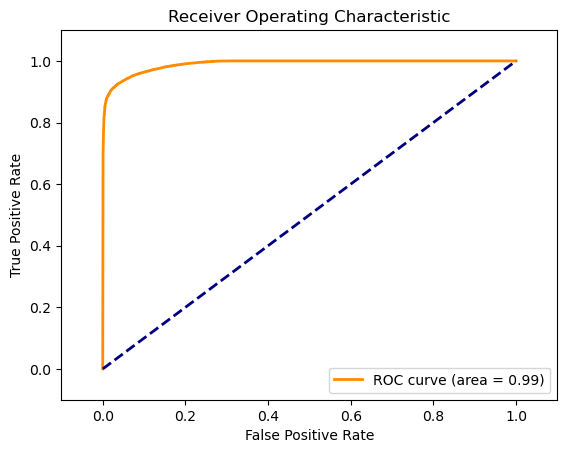

In [6]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
roc_auc_value = auc(fpr, tpr)  # Renamed the variable to avoid naming conflict

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Hyperband

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 
import optuna
import joblib
from tqdm import tqdm  # Import tqdm

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create and train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Perform Hyperband optimization with a progress bar
study = optuna.create_study(direction='maximize')

# Add tqdm to show a progress bar during optimization
with tqdm(total=100) as pbar:
    def callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=100, callbacks=[callback])

# Step 6: Get the best hyperparameters and train the model with them
best_params = study.best_params
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data using the best model
y_pred = best_rf_model.predict(X_test)

# Step 8: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 9: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

[I 2023-08-06 19:05:44,598] A new study created in memory with name: no-name-67ac9392-4edb-4993-a04a-9011bbb784cb
 46%|█████████████████████████████████████▎                                           | 46/100 [49:24<52:24, 58.23s/it][I 2023-08-06 19:56:39,746] Trial 46 finished with value: 0.9414378577665664 and parameters: {'n_estimators': 192, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 22 with value: 0.9425633064907345.


 70%|██████████████████████████████████████████████████████▌                       | 70/100 [1:26:58<56:51, 113.72s/it][I 2023-08-06 20:34:38,414] Trial 70 finished with value: 0.9422140293004754 and parameters: {'n_estimators': 194, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 62 with value: 0.9427767536625594.


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [2:01:56<07:24, 74.03s/it][I 2023-08-06 21:08:52,190] Trial 94 finished with value: 0.9421558164354322 and parameters: {'n_estimators': 164, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 83 with value: 0.9430290094110798.


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:09:00<00:00, 77.41s/it]


Best Accuracy: 0.9430290094110798
Confusion Matrix:
[[17304  1371]
 [ 1565 31295]]


### Optuna

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 
import optuna
import joblib

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create and train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Perform Optuna optimization with TPE algorithm
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

# Step 6: Get the best hyperparameters and train the model with them
best_params = study.best_params
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data using the best model
y_pred = best_rf_model.predict(X_test)

# Step 8: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 9: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


[I 2023-08-06 21:16:23,500] A new study created in memory with name: no-name-4b484232-e304-4b24-a190-38366c795bdf
[I 2023-08-06 21:17:26,087] Trial 0 finished with value: 0.9307849034636655 and parameters: {'n_estimators': 169, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9307849034636655.
[I 2023-08-06 21:17:56,546] Trial 1 finished with value: 0.9410109634229165 and parameters: {'n_estimators': 61, 'max_depth': 38, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9410109634229165.
[I 2023-08-06 21:18:58,484] Trial 2 finished with value: 0.9402930047540506 and parameters: {'n_estimators': 132, 'max_depth': 38, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9410109634229165.
[I 2023-08-06 21:19:29,263] Trial 3 finished with value: 0.9410497719996119 and parameters: {'n_estimators': 68, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value

[I 2023-08-06 21:45:46,237] Trial 36 finished with value: 0.9407393033860483 and parameters: {'n_estimators': 124, 'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 21:47:01,925] Trial 37 finished with value: 0.9412438148830892 and parameters: {'n_estimators': 156, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 21:48:15,948] Trial 38 finished with value: 0.9420587949936936 and parameters: {'n_estimators': 142, 'max_depth': 38, 'min_samples_split': 12, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 21:49:27,570] Trial 39 finished with value: 0.9413408363248278 and parameters: {'n_estimators': 141, 'max_depth': 37, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 21:50:40,651] Trial 40 finished with value: 0.9414378577665664 and 

[I 2023-08-06 22:19:29,044] Trial 72 finished with value: 0.9418647521102164 and parameters: {'n_estimators': 117, 'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 22:20:31,574] Trial 73 finished with value: 0.9421946250121277 and parameters: {'n_estimators': 119, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 22:21:14,593] Trial 74 finished with value: 0.9420781992820413 and parameters: {'n_estimators': 119, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 22:21:56,671] Trial 75 finished with value: 0.9420587949936936 and parameters: {'n_estimators': 118, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9423886678956049.
[I 2023-08-06 22:22:43,761] Trial 76 finished with value: 0.9417289220917823 and par

Best Accuracy: 0.9426215193557776
Confusion Matrix:
[[17151  1524]
 [ 1433 31427]]


['path_to_save_model.pkl']

### Bayes Search

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import joblib
from bayes_opt import BayesianOptimization
from tqdm import tqdm

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Bayesian Optimization
def objective_function(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Create and train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Define the hyperparameter search space
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

# Step 6: Perform Bayesian Optimization with progress bar
optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
total_iterations = 100  # Total number of Bayesian optimization iterations
with tqdm(total=total_iterations) as pbar:
    for _ in range(total_iterations):
        optimizer.maximize(init_points=1, n_iter=1)
        pbar.update(1)

# Step 7: Get the best hyperparameters and train the model with them
best_params = optimizer.max['params']
best_rf_model = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Step 8: Make predictions on the test data using the best model
y_pred = best_rf_model.predict(X_test)

# Step 9: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 10: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.933     | 14.36     | 9.556     | 7.856     | 139.8     |


  1%|▊                                                                               | 1/100 [00:46<1:17:01, 46.69s/it]

| 2         | 0.9395    | 23.08     | 7.013     | 3.783     | 59.58     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 3         | 0.9095    | 8.9       | 2.404     | 2.465     | 179.9     |


  2%|█▌                                                                              | 2/100 [01:33<1:16:05, 46.58s/it]

| 4         | 0.9391    | 23.71     | 6.928     | 4.62      | 59.95     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 5         | 0.939     | 20.03     | 7.373     | 2.165     | 195.5     |


  3%|██▍                                                                             | 3/100 [03:23<2:02:28, 75.76s/it]

| 6         | 0.9418    | 30.0      | 1.0       | 10.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 7         | 0.9405    | 25.81     | 2.911     | 3.455     | 77.51     |


  4%|███▏                                                                            | 4/100 [03:56<1:34:12, 58.88s/it]

| 8         | 0.8919    | 5.0       | 8.729     | 2.0       | 74.61     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 9         | 0.9289    | 12.61     | 5.723     | 5.456     | 93.68     |


  5%|████                                                                            | 5/100 [05:08<1:40:29, 63.47s/it]

| 10        | 0.939     | 30.0      | 10.0      | 10.0      | 189.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 11        | 0.9399    | 20.3      | 2.255     | 4.337     | 105.0     |


  6%|████▊                                                                           | 6/100 [06:04<1:35:23, 60.88s/it]

| 12        | 0.9391    | 30.0      | 9.996     | 10.0      | 93.68     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 13        | 0.9367    | 16.4      | 8.067     | 3.597     | 127.1     |


  7%|█████▌                                                                          | 7/100 [06:54<1:28:59, 57.42s/it]

| 14        | 0.941     | 30.0      | 1.0       | 2.0       | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 15        | 0.9392    | 19.81     | 1.418     | 6.86      | 75.58     |


  8%|██████▍                                                                         | 8/100 [07:48<1:26:10, 56.20s/it]

| 16        | 0.9417    | 29.74     | 1.784     | 9.413     | 118.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 17        | 0.8964    | 6.626     | 9.54      | 9.725     | 171.3     |


  9%|███████▏                                                                        | 9/100 [08:26<1:16:39, 50.54s/it]

| 18        | 0.8926    | 5.0       | 1.0       | 10.0      | 116.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 19        | 0.93      | 12.62     | 1.879     | 7.474     | 116.0     |


 10%|███████▉                                                                       | 10/100 [09:21<1:17:53, 51.93s/it]

| 20        | 0.9388    | 24.89     | 9.982     | 3.996     | 115.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 21        | 0.9119    | 8.051     | 5.457     | 2.275     | 186.4     |


 11%|████████▋                                                                      | 11/100 [10:31<1:25:29, 57.63s/it]

| 22        | 0.9412    | 30.0      | 1.0       | 2.0       | 135.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 23        | 0.9263    | 11.47     | 6.963     | 4.494     | 128.0     |


 12%|█████████▍                                                                     | 12/100 [11:09<1:15:41, 51.60s/it]

| 24        | 0.9358    | 14.82     | 1.0       | 10.0      | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 25        | 0.9392    | 18.67     | 2.664     | 9.757     | 166.3     |


 13%|██████████▎                                                                    | 13/100 [12:36<1:30:23, 62.34s/it]

| 26        | 0.942     | 30.0      | 1.0       | 8.93      | 156.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 27        | 0.9393    | 28.49     | 9.053     | 6.783     | 188.3     |


 14%|███████████                                                                    | 14/100 [14:13<1:44:30, 72.91s/it]

| 28        | 0.9412    | 30.0      | 1.0       | 10.0      | 172.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 29        | 0.9005    | 7.212     | 2.764     | 2.362     | 98.8      |


 15%|███████████▊                                                                   | 15/100 [15:12<1:37:01, 68.49s/it]

| 30        | 0.9389    | 30.0      | 10.0      | 2.0       | 163.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 31        | 0.9346    | 14.72     | 3.442     | 8.63      | 103.5     |


 16%|████████████▋                                                                  | 16/100 [16:00<1:27:28, 62.48s/it]

| 32        | 0.94      | 23.59     | 1.0       | 10.0      | 89.47     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 33        | 0.9285    | 12.02     | 5.884     | 3.127     | 170.3     |


 17%|█████████████▍                                                                 | 17/100 [17:15<1:31:38, 66.25s/it]

| 34        | 0.9388    | 18.0      | 1.0       | 2.0       | 155.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 35        | 0.8956    | 6.864     | 9.882     | 8.178     | 79.81     |


 18%|██████████████▏                                                                | 18/100 [18:04<1:23:10, 60.85s/it]

| 36        | 0.9385    | 30.0      | 10.0      | 10.0      | 142.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 37        | 0.8925    | 5.138     | 8.339     | 7.655     | 159.4     |


 19%|███████████████                                                                | 19/100 [19:09<1:24:00, 62.23s/it]

| 38        | 0.941     | 23.9      | 1.0       | 2.0       | 168.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 39        | 0.9408    | 24.28     | 1.666     | 4.868     | 67.38     |


 20%|███████████████▊                                                               | 20/100 [20:03<1:19:50, 59.88s/it]

| 40        | 0.94      | 23.05     | 1.0       | 10.0      | 130.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 41        | 0.9396    | 26.58     | 6.61      | 4.647     | 59.53     |


 21%|████████████████▌                                                              | 21/100 [20:49<1:13:09, 55.56s/it]

| 42        | 0.9415    | 30.0      | 1.0       | 10.0      | 104.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 43        | 0.929     | 12.77     | 3.927     | 7.837     | 145.6     |


 22%|█████████████████▍                                                             | 22/100 [22:12<1:23:05, 63.92s/it]

| 44        | 0.9392    | 29.5      | 8.684     | 2.324     | 199.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 45        | 0.9405    | 27.18     | 5.25      | 2.957     | 157.0     |


 23%|██████████████████▏                                                            | 23/100 [23:27<1:26:06, 67.09s/it]

| 46        | 0.9403    | 22.72     | 1.0       | 2.0       | 120.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 47        | 0.9396    | 24.02     | 6.051     | 8.168     | 124.1     |


 24%|██████████████████▉                                                            | 24/100 [24:26<1:21:50, 64.62s/it]

| 48        | 0.9382    | 22.14     | 10.0      | 10.0      | 104.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 49        | 0.9388    | 18.07     | 4.848     | 2.203     | 66.18     |


 25%|███████████████████▊                                                           | 25/100 [25:30<1:20:51, 64.69s/it]

| 50        | 0.9363    | 15.54     | 1.0       | 10.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 51        | 0.8922    | 5.786     | 6.728     | 4.515     | 126.3     |


 26%|████████████████████▌                                                          | 26/100 [26:06<1:08:53, 55.86s/it]

| 52        | 0.9385    | 30.0      | 10.0      | 10.0      | 75.07     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 53        | 0.941     | 27.69     | 3.244     | 5.283     | 163.3     |


 27%|█████████████████████▎                                                         | 27/100 [27:29<1:18:04, 64.16s/it]

| 54        | 0.9402    | 22.73     | 1.0       | 2.0       | 143.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 55        | 0.9201    | 10.72     | 1.693     | 4.318     | 74.18     |


 28%|██████████████████████                                                         | 28/100 [27:50<1:01:20, 51.12s/it]

| 56        | 0.8917    | 5.0       | 10.0      | 2.0       | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 57        | 0.9389    | 28.24     | 8.273     | 7.067     | 180.7     |


 29%|██████████████████████▉                                                        | 29/100 [29:05<1:08:55, 58.24s/it]

| 58        | 0.9413    | 30.0      | 1.0       | 2.0       | 93.72     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 59        | 0.9403    | 25.09     | 2.679     | 9.14      | 130.9     |


 30%|███████████████████████▋                                                       | 30/100 [30:34<1:18:56, 67.67s/it]

| 60        | 0.9417    | 30.0      | 1.0       | 2.0       | 190.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 61        | 0.939     | 25.19     | 9.065     | 4.544     | 66.51     |


 31%|████████████████████████▍                                                      | 31/100 [31:14<1:08:04, 59.20s/it]

| 62        | 0.9385    | 24.51     | 10.0      | 2.0       | 88.83     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 63        | 0.9197    | 10.7      | 4.844     | 8.544     | 179.1     |


 32%|█████████████████████████▎                                                     | 32/100 [32:42<1:16:49, 67.79s/it]

| 64        | 0.9402    | 23.81     | 1.0       | 10.0      | 186.9     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 65        | 0.8927    | 5.174     | 5.597     | 5.339     | 83.32     |


 33%|██████████████████████████                                                     | 33/100 [33:07<1:01:18, 54.90s/it]

| 66        | 0.9383    | 29.42     | 9.446     | 9.211     | 50.56     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 67        | 0.9007    | 7.997     | 4.039     | 9.543     | 98.48     |


 34%|███████████████████████████▌                                                     | 34/100 [33:54<57:48, 52.56s/it]

| 68        | 0.9396    | 23.23     | 1.337     | 9.679     | 113.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 69        | 0.9374    | 17.97     | 7.327     | 4.909     | 195.8     |


 35%|███████████████████████████▋                                                   | 35/100 [35:16<1:06:44, 61.61s/it]

| 70        | 0.9385    | 30.0      | 10.0      | 2.0       | 129.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 71        | 0.9406    | 29.06     | 3.266     | 5.978     | 95.13     |


 36%|█████████████████████████████▏                                                   | 36/100 [35:57<59:06, 55.41s/it]

| 72        | 0.9405    | 26.12     | 1.0       | 10.0      | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 73        | 0.929     | 12.12     | 1.332     | 6.877     | 125.4     |


 37%|█████████████████████████████▏                                                 | 37/100 [37:08<1:02:53, 59.90s/it]

| 74        | 0.9382    | 21.53     | 10.0      | 2.0       | 171.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 75        | 0.8958    | 6.287     | 3.508     | 9.266     | 85.93     |


 38%|██████████████████████████████▊                                                  | 38/100 [37:44<54:27, 52.70s/it]

| 76        | 0.9403    | 20.49     | 1.0       | 2.0       | 92.11     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 77        | 0.9109    | 8.622     | 5.405     | 9.885     | 86.31     |


 39%|███████████████████████████████▌                                                 | 39/100 [38:40<54:34, 53.68s/it]

| 78        | 0.9388    | 30.0      | 10.0      | 10.0      | 157.9     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 79        | 0.9391    | 21.8      | 7.855     | 3.901     | 159.2     |


 40%|███████████████████████████████▌                                               | 40/100 [40:01<1:02:04, 62.08s/it]

| 80        | 0.9415    | 30.0      | 1.0       | 10.0      | 144.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 81        | 0.9332    | 14.19     | 6.691     | 7.068     | 130.4     |


 41%|█████████████████████████████████▏                                               | 41/100 [40:52<57:50, 58.82s/it]

| 82        | 0.9373    | 19.85     | 10.0      | 10.0      | 89.23     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 83        | 0.8994    | 7.257     | 8.518     | 4.566     | 77.98     |


 42%|██████████████████████████████████                                               | 42/100 [41:33<51:39, 53.44s/it]

| 84        | 0.9384    | 30.0      | 10.0      | 2.0       | 104.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 85        | 0.8955    | 6.019     | 6.318     | 7.421     | 52.49     |


 43%|██████████████████████████████████▊                                              | 43/100 [42:37<53:45, 56.59s/it]

| 86        | 0.9407    | 25.25     | 1.119     | 3.257     | 199.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 87        | 0.938     | 17.8      | 3.038     | 7.161     | 76.15     |


 44%|███████████████████████████████████▋                                             | 44/100 [43:11<46:23, 49.71s/it]

| 88        | 0.94      | 22.12     | 1.008     | 2.152     | 53.67     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 89        | 0.9397    | 22.27     | 4.481     | 9.494     | 70.63     |


 45%|████████████████████████████████████▍                                            | 45/100 [44:21<51:14, 55.89s/it]

| 90        | 0.9387    | 23.79     | 10.0      | 10.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 91        | 0.932     | 13.53     | 2.021     | 9.398     | 181.6     |


 46%|█████████████████████████████████████▎                                           | 46/100 [45:36<55:22, 61.53s/it]

| 92        | 0.9393    | 18.02     | 1.0       | 2.0       | 133.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 93        | 0.9261    | 11.45     | 6.94      | 8.538     | 133.3     |


 47%|██████████████████████████████████████                                           | 47/100 [46:43<55:54, 63.30s/it]

| 94        | 0.9386    | 30.0      | 10.0      | 2.0       | 146.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 95        | 0.9392    | 18.24     | 3.177     | 2.745     | 184.6     |


 48%|█████████████████████████████████████▉                                         | 48/100 [48:17<1:02:51, 72.53s/it]

| 96        | 0.9398    | 21.3      | 1.356     | 8.597     | 176.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 97        | 0.94      | 27.51     | 6.698     | 4.712     | 102.4     |


 49%|██████████████████████████████████████▋                                        | 49/100 [49:26<1:00:36, 71.30s/it]

| 98        | 0.9402    | 22.8      | 1.0       | 10.0      | 151.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 99        | 0.9384    | 23.15     | 9.074     | 9.097     | 167.0     |


 50%|███████████████████████████████████████▌                                       | 50/100 [50:59<1:04:56, 77.93s/it]

| 100       | 0.9418    | 30.0      | 1.0       | 2.0       | 178.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 101       | 0.9405    | 21.05     | 1.757     | 3.293     | 184.8     |


 51%|████████████████████████████████████████▎                                      | 51/100 [52:11<1:02:11, 76.16s/it]

| 102       | 0.9416    | 30.0      | 1.0       | 10.0      | 81.12     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 103       | 0.9404    | 20.16     | 1.083     | 2.812     | 149.5     |


 52%|█████████████████████████████████████████                                      | 52/100 [53:33<1:02:12, 77.75s/it]

| 104       | 0.9413    | 30.0      | 1.0       | 2.0       | 149.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 105       | 0.8926    | 5.127     | 2.447     | 6.39      | 153.8     |


 53%|██████████████████████████████████████████▉                                      | 53/100 [54:25<54:54, 70.10s/it]

| 106       | 0.939     | 29.93     | 9.979     | 9.764     | 119.9     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 107       | 0.9402    | 21.3      | 3.018     | 7.697     | 85.59     |


 54%|███████████████████████████████████████████▋                                     | 54/100 [55:02<46:00, 60.02s/it]

| 108       | 0.9389    | 27.39     | 8.558     | 2.306     | 50.44     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 109       | 0.9308    | 13.13     | 7.718     | 7.197     | 177.4     |


 55%|████████████████████████████████████████████▌                                    | 55/100 [56:27<50:42, 67.62s/it]

| 110       | 0.9377    | 19.67     | 10.0      | 10.0      | 185.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 111       | 0.9391    | 21.44     | 6.115     | 2.749     | 105.2     |


 56%|█████████████████████████████████████████████▎                                   | 56/100 [57:25<47:31, 64.81s/it]

| 112       | 0.9414    | 29.35     | 1.233     | 2.989     | 113.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 113       | 0.9248    | 11.63     | 3.196     | 9.784     | 109.0     |


 57%|██████████████████████████████████████████████▏                                  | 57/100 [58:23<44:56, 62.70s/it]

| 114       | 0.9412    | 30.0      | 1.0       | 2.0       | 124.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 115       | 0.9402    | 27.3      | 6.68      | 8.358     | 125.4     |


 58%|██████████████████████████████████████████████▉                                  | 58/100 [59:16<41:56, 59.92s/it]

| 116       | 0.941     | 29.61     | 1.629     | 2.198     | 70.67     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 117       | 0.9389    | 19.42     | 5.433     | 3.562     | 158.4     |


 59%|██████████████████████████████████████████████▌                                | 59/100 [1:00:17<41:05, 60.13s/it]

| 118       | 0.939     | 29.83     | 8.609     | 2.063     | 78.77     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 119       | 0.93      | 12.02     | 1.219     | 7.164     | 76.57     |


 60%|███████████████████████████████████████████████▍                               | 60/100 [1:00:58<36:15, 54.38s/it]

| 120       | 0.9412    | 30.0      | 1.0       | 2.0       | 84.08     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 121       | 0.9387    | 28.51     | 9.585     | 9.319     | 105.5     |


 61%|████████████████████████████████████████████████▏                              | 61/100 [1:01:42<33:25, 51.43s/it]

| 122       | 0.9414    | 30.0      | 1.0       | 10.0      | 63.85     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 123       | 0.8925    | 5.386     | 9.355     | 5.425     | 195.0     |


 62%|████████████████████████████████████████████████▉                              | 62/100 [1:03:00<37:31, 59.26s/it]

| 124       | 0.9402    | 22.2      | 1.0       | 10.0      | 195.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 125       | 0.939     | 29.09     | 8.677     | 4.356     | 107.8     |


 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:03:44<33:45, 54.74s/it]

| 126       | 0.9392    | 19.86     | 1.177     | 9.119     | 60.84     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 127       | 0.9412    | 26.28     | 3.852     | 3.356     | 133.5     |


 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:04:47<34:20, 57.25s/it]

| 128       | 0.939     | 22.0      | 1.0       | 10.0      | 99.54     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 129       | 0.9401    | 28.4      | 7.264     | 6.56      | 64.58     |


 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:05:21<29:20, 50.30s/it]

| 130       | 0.9413    | 30.0      | 1.0       | 2.0       | 60.49     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 131       | 0.938     | 20.38     | 9.91      | 3.121     | 127.7     |


 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:06:30<31:36, 55.77s/it]

| 132       | 0.938     | 20.48     | 10.0      | 2.0       | 146.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 133       | 0.9399    | 26.93     | 7.667     | 7.576     | 155.4     |


 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:07:39<32:54, 59.84s/it]

| 134       | 0.9412    | 30.0      | 1.0       | 2.0       | 103.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 135       | 0.9317    | 13.99     | 3.642     | 8.475     | 171.5     |


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:08:53<34:09, 64.04s/it]

| 136       | 0.9415    | 30.0      | 1.0       | 10.0      | 127.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 137       | 0.9392    | 26.68     | 9.219     | 6.091     | 125.2     |


 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:10:13<35:32, 68.78s/it]

| 138       | 0.9417    | 30.0      | 1.0       | 2.0       | 168.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 139       | 0.9396    | 24.96     | 6.85      | 7.616     | 169.4     |


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:11:18<33:48, 67.62s/it]

| 140       | 0.9411    | 30.0      | 1.0       | 10.0      | 72.62     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 141       | 0.9401    | 27.25     | 4.042     | 5.005     | 64.1      |


 71%|████████████████████████████████████████████████████████                       | 71/100 [1:12:13<30:48, 63.74s/it]

| 142       | 0.9398    | 21.49     | 1.0       | 10.0      | 140.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 143       | 0.9396    | 19.46     | 1.323     | 5.725     | 131.4     |


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:13:03<27:52, 59.74s/it]

| 144       | 0.9381    | 30.0      | 10.0      | 2.0       | 61.09     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 145       | 0.9284    | 12.16     | 6.317     | 2.244     | 55.6      |


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:13:39<23:39, 52.56s/it]

| 146       | 0.9376    | 19.79     | 10.0      | 2.0       | 96.47     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 147       | 0.9402    | 25.57     | 4.242     | 3.016     | 128.3     |


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:14:52<25:27, 58.74s/it]

| 148       | 0.9417    | 30.0      | 1.0       | 10.0      | 136.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 149       | 0.9406    | 24.25     | 2.942     | 6.983     | 62.8      |


 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:15:57<25:13, 60.56s/it]

| 150       | 0.9389    | 30.0      | 10.0      | 2.0       | 182.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 151       | 0.8959    | 6.292     | 5.782     | 6.325     | 145.6     |


 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:16:32<21:13, 53.07s/it]

| 152       | 0.941     | 30.0      | 1.0       | 10.0      | 55.46     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 153       | 0.9388    | 23.15     | 9.783     | 6.13      | 98.44     |


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:17:37<21:41, 56.58s/it]

| 154       | 0.9378    | 21.56     | 10.0      | 10.0      | 146.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 155       | 0.9397    | 24.88     | 3.437     | 5.512     | 61.77     |


 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:18:46<22:04, 60.19s/it]

| 156       | 0.9396    | 19.31     | 1.0       | 2.0       | 193.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 157       | 0.8924    | 5.634     | 9.664     | 8.688     | 154.4     |


 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:19:40<20:27, 58.46s/it]

| 158       | 0.9384    | 22.8      | 10.0      | 2.0       | 137.9     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 159       | 0.9365    | 15.22     | 2.56      | 3.251     | 87.54     |


 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:20:53<20:54, 62.72s/it]

| 160       | 0.9411    | 30.0      | 1.0       | 10.0      | 183.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 161       | 0.9383    | 18.73     | 7.431     | 7.282     | 91.99     |


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:22:01<20:21, 64.27s/it]

| 162       | 0.9379    | 20.7      | 9.688     | 2.945     | 182.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 163       | 0.94      | 28.87     | 7.641     | 6.435     | 141.8     |


 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:23:31<21:39, 72.19s/it]

| 164       | 0.9401    | 30.0      | 7.963     | 10.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 165       | 0.9354    | 15.49     | 3.23      | 4.848     | 163.7     |


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:24:53<21:17, 75.14s/it]

| 166       | 0.9408    | 24.91     | 1.0       | 10.0      | 161.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 167       | 0.8921    | 5.36      | 2.045     | 2.368     | 56.11     |


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:25:13<15:36, 58.54s/it]

| 168       | 0.9379    | 20.12     | 10.0      | 10.0      | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 169       | 0.9393    | 26.39     | 7.333     | 5.793     | 64.68     |


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:25:43<12:30, 50.01s/it]

| 170       | 0.9373    | 19.49     | 10.0      | 2.0       | 53.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 171       | 0.9384    | 17.29     | 5.261     | 3.386     | 115.1     |


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:27:06<13:58, 59.91s/it]

| 172       | 0.9411    | 30.0      | 1.0       | 10.0      | 192.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 173       | 0.9334    | 14.96     | 6.543     | 7.081     | 56.8      |


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:27:44<11:34, 53.39s/it]

| 174       | 0.9412    | 30.0      | 1.0       | 10.0      | 89.84     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 175       | 0.9329    | 14.37     | 6.633     | 6.025     | 178.5     |


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:29:11<12:40, 63.34s/it]

| 176       | 0.9415    | 30.0      | 1.0       | 2.0       | 159.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 177       | 0.9399    | 21.47     | 2.466     | 2.565     | 146.4     |


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:30:25<12:11, 66.51s/it]

| 178       | 0.9385    | 30.0      | 10.0      | 10.0      | 132.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 179       | 0.8925    | 5.663     | 6.272     | 9.522     | 136.3     |


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:31:03<09:39, 57.93s/it]

| 180       | 0.9391    | 18.31     | 1.0       | 10.0      | 81.35     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 181       | 0.9332    | 14.7      | 6.79      | 5.666     | 131.8     |


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:32:02<08:44, 58.23s/it]

| 182       | 0.9371    | 18.76     | 10.0      | 10.0      | 117.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 183       | 0.9409    | 28.54     | 4.475     | 9.69      | 185.8     |


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:33:14<08:20, 62.51s/it]

| 184       | 0.9405    | 21.89     | 1.0       | 2.0       | 83.61     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 185       | 0.9185    | 9.895     | 1.624     | 2.806     | 52.73     |


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:33:56<06:33, 56.24s/it]

| 186       | 0.9413    | 30.0      | 1.0       | 10.0      | 111.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 187       | 0.8995    | 7.361     | 7.147     | 2.57      | 97.85     |


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:34:34<05:04, 50.71s/it]

| 188       | 0.9393    | 30.0      | 7.474     | 10.0      | 84.98     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 189       | 0.9409    | 26.12     | 1.209     | 8.516     | 92.28     |


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:35:13<03:56, 47.27s/it]

| 190       | 0.939     | 20.23     | 3.888     | 5.894     | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 191       | 0.8994    | 7.954     | 7.271     | 7.032     | 181.6     |


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:36:25<03:39, 54.81s/it]

| 192       | 0.9381    | 20.69     | 9.18      | 9.473     | 176.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 193       | 0.9386    | 23.38     | 8.231     | 4.256     | 76.62     |


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:37:18<02:42, 54.11s/it]

| 194       | 0.9406    | 29.78     | 5.498     | 3.162     | 118.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 195       | 0.9391    | 23.77     | 8.262     | 9.924     | 111.9     |


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:38:44<02:07, 63.87s/it]

| 196       | 0.9422    | 30.0      | 1.0       | 2.0       | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 197       | 0.9333    | 14.3      | 7.988     | 4.726     | 189.6     |


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:40:12<01:10, 70.97s/it]

| 198       | 0.9407    | 23.06     | 1.0       | 2.0       | 160.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 199       | 0.9404    | 26.46     | 4.861     | 8.007     | 163.2     |


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:41:11<00:00, 60.72s/it]

| 200       | 0.9382    | 30.0      | 10.0      | 10.0      | 59.69     |


Best Accuracy: 0.9421752207237799
Confusion Matrix:
[[17290  1385]
 [ 1595 31265]]


# Extremely Randomized Tree 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Step 1: Load the dataset
file_path = DATA  # Replace 'path/to/your/data.csv' with the actual file path
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()

# Step 4: Create and train the Extra Trees model
n_estimators=200
max_depth=50
min_samples_split=10 
min_samples_leaf=1
random_state = 42


et_model = ExtraTreesClassifier(
    n_estimators=n_estimators,
    random_state=random_state,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf
)

et_model.fit(X_train, y_train)

# Step 5: Make predictions on the test data
y_pred = et_model.predict(X_test)

end = time.time()
print(f"time:{end-start}")

# Step 6: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Step 7: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix
auc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, et_model.predict_proba(X_test))
print("AUC: {:.6f}".format(auc))
print("Log Loss: {:.6f}".format(logloss))

# import joblib
# # Save the trained classifier model to a file
# model_filename = MODEL_ET
# joblib.dump(adaboost_model, model_filename)


time:35.96705746650696
Accuracy: 0.9394974289317939
Confusion Matrix:
[[17060  1615]
 [ 1503 31357]]
AUC: 0.933891
Log Loss: 0.126423


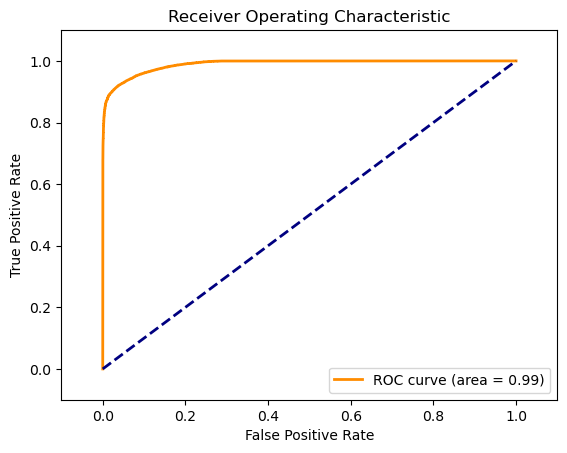

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, et_model.predict_proba(X_test)[:,1])
roc_auc_value = auc(fpr, tpr)  # Renamed the variable to avoid naming conflict

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Hyperband

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 
import optuna
import joblib
from tqdm import tqdm

# Step 1: Load the dataset
file_path = DATA  # Replace 'path/to/your/data.csv' with the actual file path
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create and train the Extra Trees model with the suggested hyperparameters
    et_model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    et_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = et_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Perform Hyperband optimization with a progress bar
sampler = optuna.integration.SkoptSampler()
study = optuna.create_study(direction='maximize', sampler=sampler)

# Add tqdm to show a progress bar during optimization
with tqdm(total=100) as pbar:
    def callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=100, callbacks=[callback])

# Step 6: Get the best hyperparameters and train the model with them
best_params = study.best_params
best_et_model = ExtraTreesClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_et_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data using the best model
y_pred = best_et_model.predict(X_test)

# Step 8: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 9: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


[I 2023-08-06 23:12:18,285] A new study created in memory with name: no-name-eed02312-6e30-4460-a3f0-fc42c2b85fcf
 28%|██████████████████████▋                                                          | 28/100 [06:33<18:10, 15.14s/it]C:\Users\KIIT\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[I 2023-08-06 23:19:21,804] Trial 28 finished with value: 0.9378286601338895 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.9388376831279713.
 43%|██████████████████████████████████▊                                              | 43/100 [10:49<11:15, 11.86s/it]C:\Users\KIIT\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[I 2023-08-06 23:23:35,727]

 48%|██████████████████████████████████████▉                                          | 48/100 [12:39<16:39, 19.22s/it]C:\Users\KIIT\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[I 2023-08-06 23:25:26,687] Trial 48 finished with value: 0.9394974289317939 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 38 with value: 0.9394974289317939.
 49%|███████████████████████████████████████▋                                         | 49/100 [13:08<18:47, 22.12s/it]C:\Users\KIIT\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[I 2023-08-06 23:25:55,386] Trial 49 finished with value: 0.9393615989133599 and parameters: {'n_estimators': 200, 'max_depth': 49, 'min_sam

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [21:04<06:22, 15.93s/it]C:\Users\KIIT\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[I 2023-08-06 23:33:51,199] Trial 76 finished with value: 0.9394974289317939 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 38 with value: 0.9394974289317939.
 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [21:32<07:33, 19.73s/it]C:\Users\KIIT\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[I 2023-08-06 23:34:19,573] Trial 77 finished with value: 0.9394974289317939 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_sam

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [27:53<00:00, 16.73s/it]


Best Accuracy: 0.9394974289317939
Confusion Matrix:
[[17060  1615]
 [ 1503 31357]]


### Optuna

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 
import optuna
import joblib
from tqdm import tqdm

# Step 1: Load the dataset
file_path = DATA  # Replace 'path/to/your/data.csv' with the actual file path
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Optuna to optimize
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create and train the Extra Trees model with the suggested hyperparameters
    et_model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    et_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = et_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Perform Optuna optimization with a progress bar
study = optuna.create_study(direction='maximize')

# Add tqdm to show a progress bar during optimization
with tqdm(total=100) as pbar:
    def callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=100, callbacks=[callback])

# Step 6: Get the best hyperparameters and train the model with them
best_params = study.best_params
best_et_model = ExtraTreesClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_et_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data using the best model
y_pred = best_et_model.predict(X_test)

# Step 8: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 9: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


[I 2023-08-06 23:49:22,163] A new study created in memory with name: no-name-ea6b0aac-8e0d-4f8d-9fb6-23937f023bbd
 46%|█████████████████████████████████████▎                                           | 46/100 [13:52<19:43, 21.92s/it][I 2023-08-07 00:03:34,235] Trial 46 finished with value: 0.9321432036480062 and parameters: {'n_estimators': 153, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 36 with value: 0.9391287474531872.


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [20:06<08:40, 17.34s/it][I 2023-08-07 00:09:44,569] Trial 70 finished with value: 0.9225380809158824 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 54 with value: 0.9392451731832735.


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [26:16<01:33, 15.53s/it][I 2023-08-07 00:15:53,628] Trial 94 finished with value: 0.9390511302997963 and parameters: {'n_estimators': 105, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 88 with value: 0.9394392160667507.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [27:33<00:00, 16.54s/it]


Best Accuracy: 0.9394586203550985
Confusion Matrix:
[[17074  1601]
 [ 1519 31341]]


### Randomized Search CV

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 
import joblib
from tqdm import tqdm  # Import tqdm for the progress bar

# Step 1: Load the dataset
file_path = DATA  # Replace 'path/to/your/data.csv' with the actual file path
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the hyperparameter search space
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Step 5: Create the Extra Trees model
et_model = ExtraTreesClassifier(random_state=42)

# Step 6: Perform Randomized Search CV with a progress bar
random_search = RandomizedSearchCV(estimator=et_model, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42)

# Use tqdm to wrap the fit method and show a progress bar
with tqdm(total=100, desc="Randomized Search CV", unit="iterations") as pbar:
    for i in range(100):
        random_search.fit(X_train, y_train)
        pbar.update(1)

# Step 7: Get the best hyperparameters and train the model with them
best_et_model = random_search.best_estimator_
best_et_model.fit(X_train, y_train)

# Step 8: Make predictions on the test data using the best model
y_pred = best_et_model.predict(X_test)

# Step 9: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 10: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Randomized Search CV:   1%|▍                                           | 1/100 [1:03:14<104:21:44, 3794.99s/iterations]

### Bayes

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time 
import joblib
from bayes_opt import BayesianOptimization

# Step 1: Load the dataset
file_path = DATA  # Replace 'path/to/your/data.csv' with the actual file path
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Bayesian Optimization
def objective_function(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Create and train the Extra Trees model with the suggested hyperparameters
    et_model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    et_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = et_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Define the hyperparameter search space
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

# Step 6: Perform Bayesian Optimization
optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=90)

# Step 7: Get the best hyperparameters and train the model with them
best_params = optimizer.max['params']
best_et_model = ExtraTreesClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)
best_et_model.fit(X_train, y_train)

# Step 8: Make predictions on the test data using the best model
y_pred = best_et_model.predict(X_test)

# Step 9: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 10: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8976    | 21.85     | 9.556     | 15.18     | 139.8     |
| 2         | 0.8938    | 12.02     | 2.404     | 3.046     | 179.9     |
| 3         | 0.9199    | 32.05     | 7.373     | 2.371     | 195.5     |
| 4         | 0.9359    | 42.46     | 2.911     | 5.273     | 77.51     |
| 5         | 0.8969    | 18.69     | 5.723     | 9.775     | 93.68     |
| 6         | 0.9293    | 32.53     | 2.255     | 7.259     | 105.0     |
| 7         | 0.9064    | 25.52     | 8.067     | 5.594     | 127.1     |
| 8         | 0.9295    | 31.66     | 1.418     | 12.94     | 75.58     |
| 9         | 0.8906    | 7.927     | 9.54      | 19.38     | 171.3     |
| 10        | 0.9004    | 18.71     | 1.879     | 14.32     | 116.0     |
| 11        | 0.9393    | 50.0      | 1.0       | 10.29     | 96.14     |
| 12        | 0.9371    | 50.0      | 

| 67        | 0.9389    | 46.05     | 1.0       | 8.137     | 168.4     |
| 68        | 0.9376    | 43.83     | 1.0       | 12.57     | 132.6     |
| 69        | 0.9395    | 50.0      | 1.0       | 8.884     | 123.0     |
| 70        | 0.9372    | 41.92     | 1.0       | 2.0       | 80.24     |
| 71        | 0.9396    | 50.0      | 1.0       | 9.812     | 182.9     |
| 72        | 0.9368    | 50.0      | 1.0       | 20.0      | 88.94     |
| 73        | 0.9381    | 44.69     | 1.0       | 7.714     | 75.0      |
| 74        | 0.9382    | 50.0      | 1.0       | 15.68     | 165.4     |
| 75        | 0.9384    | 50.0      | 1.0       | 11.06     | 61.83     |
| 76        | 0.9378    | 46.56     | 1.0       | 5.869     | 127.2     |
| 77        | 0.9392    | 50.0      | 1.0       | 7.972     | 107.0     |
| 78        | 0.9375    | 45.72     | 1.0       | 2.0       | 142.2     |
| 79        | 0.9396    | 50.0      | 1.0       | 10.9      | 146.9     |
| 80        | 0.9393    | 50.0      | 

# Decision Tree

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Step 1: Load the dataset
file_path = DATA  # Replace 'path/to/your/data.csv' with the actual file path
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()

# Step 4: Create and train the Decision Tree model
max_depth = 19  # Replace None with the desired value, or keep it as None for unlimited depth
min_samples_split = 15 # Replace 2 with the desired value
min_samples_leaf = 6  # Replace 1 with the desired value

dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf
)

dt_model.fit(X_train, y_train)

# Step 5: Make predictions on the test data
y_pred = dt_model.predict(X_test)

end = time.time()
print(f"time:{end-start}")

# Step 6: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Step 7: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix
auc = roc_auc_score(y_test, y_pred)
logloss = log_loss(y_test, dt_model.predict_proba(X_test))
print("AUC: {:.6f}".format(auc))
print("Log Loss: {:.6f}".format(logloss))

# import joblib
# # Save the trained classifier model to a file
# model_filename = MODEL_DT
# joblib.dump(adaboost_model, model_filename)

time:3.4327125549316406
Accuracy: 0.9334432909673038
Confusion Matrix:
[[17281  1394]
 [ 2036 30824]]
AUC: 0.931697
Log Loss: 0.260313


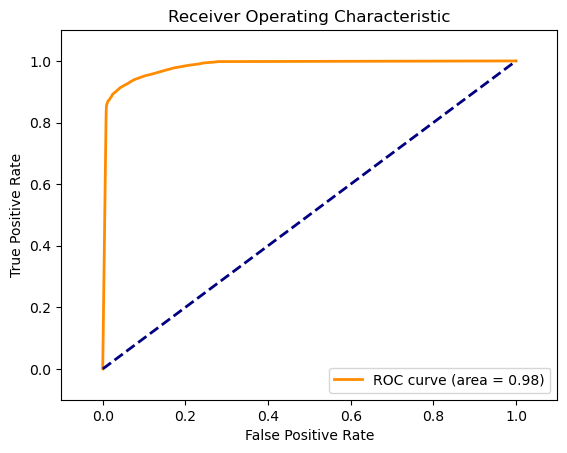

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:,1])
roc_auc_value = auc(fpr, tpr)  # Renamed the variable to avoid naming conflict

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Optuna

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import joblib
import optuna
from tqdm import tqdm

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameter search space for Decision Tree
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    dt_model.fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Step 5: Perform Optuna optimization with progress bar
study = optuna.create_study(direction='maximize')
with tqdm(total=100) as pbar:
    def progress_callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=100, show_progress_bar=False, callbacks=[progress_callback])

# Step 6: Get the best hyperparameters and train the model with them
best_params = study.best_params
best_dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_dt_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data using the best model
y_pred = best_dt_model.predict(X_test)

# Step 8: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 9: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


[I 2023-08-07 00:17:10,704] A new study created in memory with name: no-name-d6b00556-dd93-45a2-9152-f7c5a8d85774
 24%|███████████████████▍                                                             | 24/100 [01:02<03:37,  2.87s/it][I 2023-08-07 00:18:15,810] Trial 24 finished with value: 0.9331134180653925 and parameters: {'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 24 with value: 0.9331134180653925.


 49%|███████████████████████████████████████▋                                         | 49/100 [02:08<02:16,  2.68s/it][I 2023-08-07 00:19:22,358] Trial 49 finished with value: 0.932511885126613 and parameters: {'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 27 with value: 0.9334044823906084.


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:21<00:02,  2.72s/it][I 2023-08-07 00:21:34,748] Trial 99 finished with value: 0.9301251576598428 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 65 with value: 0.9334432909673038.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.64s/it]


Best Accuracy: 0.9334432909673038
Confusion Matrix:
[[17281  1394]
 [ 2036 30824]]


### Randomized Search CV

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import joblib

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the hyperparameter search space
param_dist = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 10]
}

# Step 5: Create the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Step 6: Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    dt_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=1
)

start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
print(f"time:{end-start}")

# Step 7: Get the best hyperparameters and train the model with them
best_dt_model = random_search.best_estimator_

# Step 8: Make predictions on the test data using the best model
y_pred = best_dt_model.predict(X_test)

# Step 9: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 10: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
time:271.892053604126
Best Accuracy: 0.9329387794702629
Confusion Matrix:
[[17255  1420]
 [ 2036 30824]]


### Bayes Search

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import joblib
from bayes_opt import BayesianOptimization
from tqdm import tqdm

# Step 1: Load the dataset
file_path = DATA
df = pd.read_csv(file_path)

# Step 2: Prepare the data
X = df.drop('label', axis=1)
y = df['label']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define the objective function for Bayesian Optimization
def objective_function(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Create and train the Decision Tree model with the suggested hyperparameters
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    dt_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = dt_model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Step 5: Define the hyperparameter search space
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

# Step 6: Perform Bayesian Optimization with custom progress bar
optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds, random_state=42)
total_iterations = 100  # Total number of Bayesian optimization iterations
with tqdm(total=total_iterations) as pbar:
    for _ in range(total_iterations):
        optimizer.maximize(init_points=1, n_iter=1)
        pbar.update(1)

# Step 7: Get the best hyperparameters and train the model with them
best_params = optimizer.max['params']
best_dt_model = DecisionTreeClassifier(
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)
best_dt_model.fit(X_train, y_train)

# Step 8: Make predictions on the test data using the best model
y_pred = best_dt_model.predict(X_test)

# Step 9: Evaluate the model's performance on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")

# Step 10: Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9265    | 14.36     | 9.556     | 15.18     | 139.8     |


  1%|▊                                                                                 | 1/100 [00:05<08:47,  5.32s/it]

| 2         | 0.9326    | 23.08     | 7.013     | 6.011     | 59.58     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 3         | 0.9101    | 8.9       | 2.404     | 3.046     | 179.9     |


  2%|█▋                                                                                | 2/100 [00:09<07:52,  4.82s/it]

| 4         | 0.9327    | 23.9      | 6.983     | 4.802     | 59.37     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 5         | 0.9327    | 20.03     | 7.373     | 2.371     | 195.5     |


  3%|██▍                                                                               | 3/100 [00:15<08:25,  5.21s/it]

| 6         | 0.9312    | 30.0      | 10.0      | 12.33     | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 7         | 0.9314    | 25.81     | 2.911     | 5.273     | 77.51     |


  4%|███▎                                                                              | 4/100 [00:19<07:43,  4.83s/it]

| 8         | 0.8987    | 6.643     | 6.825     | 2.242     | 72.46     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 9         | 0.9201    | 12.61     | 5.723     | 9.775     | 93.68     |


  5%|████                                                                              | 5/100 [00:25<07:54,  5.00s/it]

| 10        | 0.9307    | 30.0      | 1.0       | 13.37     | 66.06     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 11        | 0.9321    | 20.3      | 2.255     | 7.259     | 105.0     |


  6%|████▉                                                                             | 6/100 [00:30<08:12,  5.24s/it]

| 12        | 0.9312    | 30.0      | 10.0      | 14.57     | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 13        | 0.929     | 16.4      | 8.067     | 5.594     | 127.1     |


  7%|█████▋                                                                            | 7/100 [00:36<08:22,  5.41s/it]

| 14        | 0.9313    | 30.0      | 1.0       | 18.57     | 115.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 15        | 0.933     | 19.81     | 1.418     | 12.94     | 75.58     |


  8%|██████▌                                                                           | 8/100 [00:42<08:31,  5.56s/it]

| 16        | 0.9313    | 30.0      | 1.0       | 20.0      | 83.63     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 17        | 0.8987    | 6.626     | 9.54      | 19.38     | 171.3     |


  9%|███████▍                                                                          | 9/100 [00:44<06:54,  4.56s/it]

| 18        | 0.8979    | 5.0       | 1.0       | 20.0      | 118.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 19        | 0.9203    | 12.62     | 1.879     | 14.32     | 116.0     |


 10%|████████                                                                         | 10/100 [00:49<07:04,  4.72s/it]

| 20        | 0.9312    | 30.0      | 10.0      | 2.0       | 115.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 21        | 0.9101    | 8.051     | 5.457     | 2.619     | 186.4     |


 11%|████████▉                                                                        | 11/100 [00:54<06:59,  4.72s/it]

| 22        | 0.9313    | 30.0      | 1.0       | 2.0       | 139.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 23        | 0.9191    | 11.47     | 6.963     | 7.611     | 128.0     |


 12%|█████████▋                                                                       | 12/100 [00:59<07:01,  4.79s/it]

| 24        | 0.9312    | 30.0      | 10.0      | 16.54     | 132.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 25        | 0.9309    | 18.67     | 2.664     | 19.45     | 166.3     |


 13%|██████████▌                                                                      | 13/100 [01:05<07:20,  5.07s/it]

| 26        | 0.9313    | 30.0      | 1.0       | 19.11     | 155.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 27        | 0.9313    | 28.49     | 9.053     | 12.76     | 188.3     |


 14%|███████████▎                                                                     | 14/100 [01:10<07:34,  5.28s/it]

| 28        | 0.9306    | 30.0      | 9.714     | 2.343     | 160.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 29        | 0.8989    | 7.212     | 2.764     | 2.814     | 98.8      |


 15%|████████████▏                                                                    | 15/100 [01:15<07:03,  4.98s/it]

| 30        | 0.9312    | 30.0      | 10.0      | 15.17     | 98.97     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 31        | 0.9269    | 14.72     | 3.442     | 16.92     | 103.5     |


 16%|████████████▉                                                                    | 16/100 [01:20<07:09,  5.11s/it]

| 32        | 0.9313    | 30.0      | 1.0       | 20.0      | 173.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 33        | 0.9201    | 12.02     | 5.884     | 4.537     | 170.3     |


 17%|█████████████▊                                                                   | 17/100 [01:25<06:49,  4.93s/it]

| 34        | 0.9236    | 13.74     | 1.0       | 20.0      | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 35        | 0.8987    | 6.864     | 9.882     | 15.9      | 79.81     |


 18%|██████████████▌                                                                  | 18/100 [01:29<06:31,  4.78s/it]

| 36        | 0.9313    | 30.0      | 1.0       | 2.0       | 179.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 37        | 0.8979    | 5.138     | 8.339     | 14.72     | 159.4     |


 19%|███████████████▍                                                                 | 19/100 [01:33<06:12,  4.60s/it]

| 38        | 0.9313    | 30.0      | 1.0       | 2.0       | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 39        | 0.9333    | 24.28     | 1.666     | 8.452     | 67.38     |


 20%|████████████████▏                                                                | 20/100 [01:39<06:41,  5.02s/it]

| 40        | 0.9313    | 30.0      | 1.0       | 2.0       | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 41        | 0.9319    | 26.58     | 6.61      | 7.956     | 59.53     |


 21%|█████████████████                                                                | 21/100 [01:45<06:54,  5.24s/it]

| 42        | 0.9329    | 19.09     | 1.0       | 20.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 43        | 0.9201    | 12.77     | 3.927     | 15.13     | 145.6     |


 22%|█████████████████▊                                                               | 22/100 [01:50<06:49,  5.25s/it]

| 44        | 0.9305    | 30.0      | 1.0       | 4.646     | 94.83     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 45        | 0.9313    | 27.18     | 5.25      | 4.153     | 157.0     |


 23%|██████████████████▋                                                              | 23/100 [01:56<07:05,  5.52s/it]

| 46        | 0.9313    | 28.14     | 1.0       | 4.503     | 123.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 47        | 0.9327    | 24.02     | 6.051     | 15.88     | 124.1     |


 24%|███████████████████▍                                                             | 24/100 [02:02<07:07,  5.63s/it]

| 48        | 0.9334    | 23.37     | 10.0      | 2.0       | 140.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 49        | 0.9307    | 18.07     | 4.848     | 2.458     | 66.18     |


 25%|████████████████████▎                                                            | 25/100 [02:08<07:01,  5.62s/it]

| 50        | 0.9312    | 30.0      | 10.0      | 20.0      | 164.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 51        | 0.8979    | 5.786     | 6.728     | 7.658     | 126.3     |


 26%|█████████████████████                                                            | 26/100 [02:12<06:22,  5.17s/it]

| 52        | 0.9313    | 30.0      | 1.0       | 20.0      | 195.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 53        | 0.9305    | 27.69     | 3.244     | 9.387     | 163.3     |


 27%|█████████████████████▊                                                           | 27/100 [02:18<06:33,  5.40s/it]

| 54        | 0.9312    | 30.0      | 10.0      | 20.0      | 72.55     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 55        | 0.9179    | 10.72     | 1.693     | 7.216     | 74.18     |


 28%|██████████████████████▋                                                          | 28/100 [02:22<06:01,  5.02s/it]

| 56        | 0.9205    | 12.92     | 1.654     | 3.075     | 50.18     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 57        | 0.931     | 28.24     | 8.273     | 13.4      | 180.7     |


 29%|███████████████████████▍                                                         | 29/100 [02:28<06:16,  5.31s/it]

| 58        | 0.9334    | 24.99     | 1.0       | 20.0      | 97.94     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 59        | 0.9325    | 25.09     | 2.679     | 18.07     | 130.9     |


 30%|████████████████████████▎                                                        | 30/100 [02:34<06:25,  5.51s/it]

| 60        | 0.9312    | 30.0      | 10.0      | 12.7      | 146.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 61        | 0.9322    | 25.19     | 9.065     | 7.724     | 66.51     |


 31%|█████████████████████████                                                        | 31/100 [02:40<06:26,  5.61s/it]

| 62        | 0.9312    | 30.0      | 10.0      | 2.0       | 189.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 63        | 0.9177    | 10.7      | 4.844     | 16.72     | 179.1     |


 32%|█████████████████████████▉                                                       | 32/100 [02:44<05:57,  5.25s/it]

| 64        | 0.9282    | 15.11     | 9.838     | 18.38     | 198.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 65        | 0.8979    | 5.174     | 5.597     | 9.513     | 83.32     |


 33%|██████████████████████████▋                                                      | 33/100 [02:48<05:26,  4.88s/it]

| 66        | 0.9334    | 23.75     | 10.0      | 13.41     | 110.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 67        | 0.8987    | 7.997     | 4.039     | 18.97     | 98.48     |


 34%|███████████████████████████▌                                                     | 34/100 [02:53<05:13,  4.75s/it]

| 68        | 0.9332    | 24.68     | 10.0      | 9.106     | 89.85     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 69        | 0.9299    | 17.97     | 7.327     | 8.545     | 195.8     |


 35%|████████████████████████████▎                                                    | 35/100 [02:58<05:26,  5.02s/it]

| 70        | 0.9328    | 21.81     | 1.0       | 20.0      | 185.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 71        | 0.9295    | 29.06     | 3.266     | 10.95     | 95.13     |


 36%|█████████████████████████████▏                                                   | 36/100 [03:05<05:42,  5.35s/it]

| 72        | 0.9328    | 22.24     | 1.0       | 20.0      | 108.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 73        | 0.9202    | 12.12     | 1.332     | 12.97     | 125.4     |


 37%|█████████████████████████████▉                                                   | 37/100 [03:10<05:31,  5.25s/it]

| 74        | 0.9328    | 21.22     | 1.0       | 8.021     | 136.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 75        | 0.8987    | 6.287     | 3.508     | 18.35     | 85.93     |


 38%|██████████████████████████████▊                                                  | 38/100 [03:14<05:06,  4.95s/it]

| 76        | 0.9312    | 30.0      | 10.0      | 2.0       | 131.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 77        | 0.91      | 8.622     | 5.405     | 19.74     | 86.31     |


 39%|███████████████████████████████▌                                                 | 39/100 [03:18<04:53,  4.81s/it]

| 78        | 0.9323    | 21.94     | 10.0      | 20.0      | 88.97     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 79        | 0.9325    | 21.8      | 7.855     | 6.277     | 159.2     |


 40%|████████████████████████████████▍                                                | 40/100 [03:24<05:08,  5.14s/it]

| 80        | 0.9313    | 30.0      | 1.0       | 20.0      | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 81        | 0.9269    | 14.19     | 6.691     | 13.4      | 130.4     |


 41%|█████████████████████████████████▏                                               | 41/100 [03:30<05:07,  5.21s/it]

| 82        | 0.9312    | 30.0      | 10.0      | 2.0       | 100.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 83        | 0.8988    | 7.257     | 8.518     | 7.774     | 77.98     |


 42%|██████████████████████████████████                                               | 42/100 [03:34<04:45,  4.92s/it]

| 84        | 0.9323    | 21.58     | 10.0      | 20.0      | 102.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 85        | 0.8987    | 6.019     | 6.318     | 14.2      | 52.49     |


 43%|██████████████████████████████████▊                                              | 43/100 [03:38<04:29,  4.73s/it]

| 86        | 0.9328    | 22.32     | 1.0       | 20.0      | 63.97     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 87        | 0.9297    | 17.8      | 3.038     | 13.61     | 76.15     |


 44%|███████████████████████████████████▋                                             | 44/100 [03:42<04:08,  4.44s/it]

| 88        | 0.8979    | 5.0       | 1.0       | 20.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 89        | 0.9321    | 22.27     | 4.481     | 18.86     | 70.63     |


 45%|████████████████████████████████████▍                                            | 45/100 [03:48<04:27,  4.86s/it]

| 90        | 0.9332    | 24.49     | 10.0      | 20.0      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 91        | 0.9236    | 13.53     | 2.021     | 18.64     | 181.6     |


 46%|█████████████████████████████████████▎                                           | 46/100 [03:53<04:29,  5.00s/it]

| 92        | 0.9332    | 24.07     | 10.0      | 2.0       | 174.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 93        | 0.919     | 11.45     | 6.94      | 16.71     | 133.3     |


 47%|██████████████████████████████████████                                           | 47/100 [03:58<04:28,  5.07s/it]

| 94        | 0.9313    | 30.0      | 1.0       | 20.0      | 142.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 95        | 0.9305    | 18.24     | 3.177     | 3.676     | 184.6     |


 48%|██████████████████████████████████████▉                                          | 48/100 [04:04<04:33,  5.26s/it]

| 96        | 0.9328    | 20.87     | 1.0       | 20.0      | 84.87     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 97        | 0.9325    | 27.51     | 6.698     | 8.103     | 102.4     |


 49%|███████████████████████████████████████▋                                         | 49/100 [04:10<04:39,  5.48s/it]

| 98        | 0.9324    | 22.31     | 1.0       | 11.56     | 175.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 99        | 0.933     | 23.15     | 9.074     | 17.97     | 167.0     |


 50%|████████████████████████████████████████▌                                        | 50/100 [04:16<04:40,  5.61s/it]

| 100       | 0.933     | 25.25     | 1.0       | 7.953     | 191.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 101       | 0.9329    | 21.05     | 1.757     | 4.909     | 184.8     |


 51%|█████████████████████████████████████████▎                                       | 51/100 [04:22<04:37,  5.67s/it]

| 102       | 0.9332    | 24.08     | 10.0      | 20.0      | 150.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 103       | 0.9328    | 20.16     | 1.083     | 3.826     | 149.5     |


 52%|██████████████████████████████████████████                                       | 52/100 [04:27<04:33,  5.69s/it]

| 104       | 0.9331    | 21.46     | 1.0       | 2.0       | 87.26     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 105       | 0.8979    | 5.127     | 2.447     | 11.88     | 153.8     |


 53%|██████████████████████████████████████████▉                                      | 53/100 [04:32<04:05,  5.23s/it]

| 106       | 0.9308    | 29.48     | 9.877     | 19.13     | 59.37     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 107       | 0.9322    | 21.3      | 3.018     | 14.82     | 85.59     |


 54%|███████████████████████████████████████████▋                                     | 54/100 [04:37<04:09,  5.42s/it]

| 108       | 0.9312    | 30.0      | 10.0      | 2.0       | 84.79     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 109       | 0.9231    | 13.13     | 7.718     | 13.69     | 177.4     |


 55%|████████████████████████████████████████████▌                                    | 55/100 [04:43<04:03,  5.41s/it]

| 110       | 0.9312    | 30.0      | 10.0      | 2.0       | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 111       | 0.9324    | 21.44     | 6.115     | 3.686     | 105.2     |


 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:49<04:02,  5.52s/it]

| 112       | 0.9323    | 21.51     | 10.0      | 20.0      | 188.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 113       | 0.919     | 11.63     | 3.196     | 19.51     | 109.0     |


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:54<03:52,  5.42s/it]

| 114       | 0.9313    | 30.0      | 1.0       | 2.0       | 109.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 115       | 0.9328    | 27.3      | 6.68      | 16.31     | 125.4     |


 58%|██████████████████████████████████████████████▉                                  | 58/100 [05:00<03:54,  5.59s/it]

| 116       | 0.933     | 24.79     | 1.0       | 14.2      | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 117       | 0.9329    | 19.42     | 5.433     | 5.514     | 158.4     |


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:05<03:49,  5.60s/it]

| 118       | 0.9319    | 19.69     | 10.0      | 2.0       | 151.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 119       | 0.9203    | 12.02     | 1.219     | 13.62     | 76.57     |


 60%|████████████████████████████████████████████████▌                                | 60/100 [05:11<03:39,  5.48s/it]

| 120       | 0.9329    | 22.47     | 1.0       | 2.0       | 165.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 121       | 0.9313    | 28.51     | 9.585     | 18.47     | 105.5     |


 61%|█████████████████████████████████████████████████▍                               | 61/100 [05:16<03:36,  5.55s/it]

| 122       | 0.9328    | 22.14     | 10.0      | 2.0       | 93.58     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 123       | 0.8979    | 5.386     | 9.355     | 9.707     | 195.0     |


 62%|██████████████████████████████████████████████████▏                              | 62/100 [05:20<03:13,  5.08s/it]

| 124       | 0.933     | 23.84     | 9.953     | 10.68     | 138.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 125       | 0.9308    | 29.09     | 8.677     | 7.3       | 107.8     |


 63%|███████████████████████████████████████████████████                              | 63/100 [05:26<03:17,  5.34s/it]

| 126       | 0.932     | 26.92     | 9.94      | 2.227     | 199.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 127       | 0.9311    | 26.28     | 3.852     | 5.051     | 133.5     |


 64%|███████████████████████████████████████████████████▊                             | 64/100 [05:32<03:18,  5.52s/it]

| 128       | 0.9328    | 22.14     | 10.0      | 2.0       | 185.9     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 129       | 0.931     | 28.4      | 7.264     | 12.26     | 64.58     |


 65%|████████████████████████████████████████████████████▋                            | 65/100 [05:38<03:19,  5.70s/it]

| 130       | 0.9326    | 24.05     | 1.0       | 11.52     | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 131       | 0.9323    | 20.38     | 9.91      | 4.522     | 127.7     |


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [05:44<03:13,  5.70s/it]

| 132       | 0.9323    | 21.36     | 10.0      | 11.05     | 99.78     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 133       | 0.9313    | 26.93     | 7.667     | 14.55     | 155.4     |


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [05:50<03:11,  5.80s/it]

| 134       | 0.9324    | 21.97     | 4.417     | 20.0      | 194.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 135       | 0.9234    | 13.99     | 3.642     | 16.57     | 171.5     |


 68%|███████████████████████████████████████████████████████                          | 68/100 [05:55<03:01,  5.69s/it]

| 136       | 0.9329    | 24.13     | 1.0       | 12.9      | 147.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 137       | 0.932     | 26.68     | 9.219     | 11.2      | 125.2     |


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [06:01<02:59,  5.78s/it]

| 138       | 0.9312    | 30.0      | 10.0      | 20.0      | 119.3     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 139       | 0.933     | 24.96     | 6.85      | 14.64     | 169.4     |


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:08<02:55,  5.86s/it]

| 140       | 0.9329    | 26.98     | 1.0       | 20.0      | 73.78     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 141       | 0.93      | 27.25     | 4.042     | 8.76      | 64.1      |


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [06:13<02:50,  5.88s/it]

| 142       | 0.9326    | 24.05     | 6.72      | 19.56     | 177.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 143       | 0.9329    | 19.46     | 1.323     | 10.38     | 131.4     |


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [06:19<02:43,  5.84s/it]

| 144       | 0.9331    | 21.08     | 1.0       | 2.0       | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 145       | 0.9203    | 12.16     | 6.317     | 2.549     | 55.6      |


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [06:24<02:31,  5.60s/it]

| 146       | 0.9334    | 23.61     | 10.0      | 20.0      | 139.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 147       | 0.9309    | 25.57     | 4.242     | 4.287     | 128.3     |


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [06:30<02:28,  5.70s/it]

| 148       | 0.9326    | 23.6      | 1.0       | 10.31     | 114.5     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 149       | 0.9324    | 24.25     | 2.942     | 13.21     | 62.8      |


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [06:36<02:24,  5.79s/it]

| 150       | 0.933     | 25.25     | 1.0       | 20.0      | 164.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 151       | 0.8987    | 6.292     | 5.782     | 11.73     | 145.6     |


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [06:40<02:08,  5.34s/it]

| 152       | 0.9329    | 20.73     | 1.0       | 2.0       | 60.33     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 153       | 0.933     | 23.15     | 9.783     | 11.29     | 98.44     |


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [06:46<02:06,  5.52s/it]

| 154       | 0.9328    | 22.15     | 1.0       | 20.0      | 152.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 155       | 0.9318    | 24.88     | 3.437     | 9.901     | 61.77     |


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [06:52<02:03,  5.63s/it]

| 156       | 0.9319    | 22.28     | 4.202     | 15.22     | 104.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 157       | 0.8979    | 5.634     | 9.664     | 17.05     | 154.4     |


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [06:56<01:48,  5.17s/it]

| 158       | 0.933     | 23.47     | 1.0       | 2.0       | 98.03     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 159       | 0.9281    | 15.22     | 2.56      | 4.816     | 87.54     |


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:02<01:48,  5.40s/it]

| 160       | 0.9312    | 30.0      | 10.0      | 2.0       | 146.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 161       | 0.9312    | 18.73     | 7.431     | 13.88     | 91.99     |


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [07:09<01:48,  5.73s/it]

| 162       | 0.9313    | 30.0      | 1.0       | 20.0      | 125.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 163       | 0.931     | 28.87     | 7.641     | 11.98     | 141.8     |


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [07:15<01:45,  5.86s/it]

| 164       | 0.9331    | 21.12     | 1.0       | 2.0       | 72.67     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 165       | 0.928     | 15.49     | 3.23      | 8.408     | 163.7     |


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [07:21<01:38,  5.79s/it]

| 166       | 0.9332    | 24.11     | 1.888     | 2.573     | 192.1     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 167       | 0.8979    | 5.36      | 2.045     | 2.828     | 56.11     |


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [07:25<01:23,  5.25s/it]

| 168       | 0.9325    | 22.68     | 9.29      | 3.811     | 51.93     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 169       | 0.9313    | 26.39     | 7.333     | 10.54     | 64.68     |


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [07:30<01:21,  5.43s/it]

| 170       | 0.9323    | 21.21     | 10.0      | 20.0      | 113.9     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 171       | 0.9298    | 17.29     | 5.261     | 5.118     | 115.1     |


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [07:36<01:17,  5.54s/it]

| 172       | 0.9328    | 21.52     | 1.0       | 20.0      | 141.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 173       | 0.9269    | 14.96     | 6.543     | 13.43     | 56.8      |


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [07:42<01:11,  5.47s/it]

| 174       | 0.9323    | 21.95     | 10.0      | 20.0      | 50.0      |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 175       | 0.9269    | 14.37     | 6.633     | 11.06     | 178.5     |


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [07:47<01:05,  5.49s/it]

| 176       | 0.9324    | 21.55     | 6.862     | 11.41     | 184.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 177       | 0.9317    | 21.47     | 2.466     | 3.27      | 146.4     |


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [07:53<01:02,  5.66s/it]

| 178       | 0.933     | 23.04     | 1.0       | 2.0       | 115.7     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 179       | 0.8979    | 5.663     | 6.272     | 18.92     | 136.3     |


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [07:57<00:51,  5.19s/it]

| 180       | 0.9328    | 22.6      | 10.0      | 2.0       | 117.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 181       | 0.9269    | 14.7      | 6.79      | 10.25     | 131.8     |


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:03<00:47,  5.25s/it]

| 182       | 0.9323    | 21.75     | 10.0      | 20.0      | 129.4     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 183       | 0.9307    | 28.54     | 4.475     | 19.3      | 185.8     |


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [08:09<00:43,  5.50s/it]

| 184       | 0.9332    | 23.73     | 1.042     | 18.46     | 53.89     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 185       | 0.9115    | 9.895     | 1.624     | 3.814     | 52.73     |


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [08:14<00:37,  5.31s/it]

| 186       | 0.9329    | 21.66     | 1.0       | 9.909     | 156.8     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 187       | 0.8988    | 7.361     | 7.147     | 3.281     | 97.85     |


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [08:18<00:30,  5.03s/it]

| 188       | 0.9323    | 21.81     | 10.0      | 13.12     | 146.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 189       | 0.9329    | 26.12     | 1.209     | 16.66     | 92.28     |


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [08:24<00:26,  5.28s/it]

| 190       | 0.9328    | 22.36     | 10.0      | 11.96     | 200.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 191       | 0.8988    | 7.954     | 7.271     | 13.32     | 181.6     |


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [08:28<00:20,  5.02s/it]

| 192       | 0.9323    | 21.8      | 10.0      | 9.352     | 175.6     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 193       | 0.9328    | 23.38     | 8.231     | 7.077     | 76.62     |


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [08:34<00:15,  5.30s/it]

| 194       | 0.9312    | 30.0      | 10.0      | 20.0      | 89.56     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 195       | 0.9332    | 23.77     | 8.262     | 19.83     | 111.9     |


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [08:40<00:11,  5.54s/it]

| 196       | 0.9312    | 30.0      | 10.0      | 2.0       | 177.2     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 197       | 0.9266    | 14.3      | 7.988     | 8.134     | 189.6     |


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [08:46<00:05,  5.50s/it]

| 198       | 0.9323    | 21.31     | 10.0      | 2.0       | 165.0     |
|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 199       | 0.9316    | 26.46     | 4.861     | 15.52     | 163.2     |


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:52<00:00,  5.32s/it]

| 200       | 0.9307    | 29.2      | 9.782     | 2.394     | 69.96     |


Best Accuracy: 0.9333850781022606
Confusion Matrix:
[[17250  1425]
 [ 2008 30852]]
